# PyTorch Cognitive Radio - Channel occupancy prediction using LSTM


>[PyTorch Cognitive Radio - Channel occupancy prediction using LSTM](#scrollTo=szOWLo_3FYsy)

>>[1. Import libraries & setup](#scrollTo=R-uOLgZWcB4I)

>>[2. Hyperparameters](#scrollTo=8-eDK_jJLcMN)

>>[3. Plotting functions](#scrollTo=T-6tgFbULffj)

>>[4. Simulate channel data](#scrollTo=gVkPvKYpLuhe)

>>[5. Sequence creation & DataLoader](#scrollTo=7-D_fGKNL6Jz)

>>[6. LSTM model definition](#scrollTo=NXTUz7rOMFLL)

>>[7. Training loop](#scrollTo=RHSHqKGMMUZw)

>>[8. Evaluate model on new dataset](#scrollTo=0AvRdlELMbBy)



## 1.&nbsp;Import libraries & setup
Imports all related libraries & installs packages (includes optional visualization libs), may require re-run after runtime restart.

In [1]:
import importlib
def ensure(pkg, pip_name=None):
    pip_name = pip_name or pkg
    try:
        importlib.import_module(pkg)
        print(f"{pkg} already installed.")
    except ImportError:
        print(f"Installing {pip_name}...")
        !pip install -q {pip_name}

ensure("torchview")
ensure("torchviz")
ensure("torch_summary", "torch-summary")
ensure("seaborn")

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from torchview import draw_graph
from torchsummary import summary


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Installing torchview...
Installing torchviz...
Installing torch-summary...
seaborn already installed.
Using device: cuda


## 2.&nbsp;Hyperparameters
Central config dictionary - change values here

In [2]:
config = {
    'num_channels': 5,
    'signal_length': 100000,
    'input_window': 500,
    'horizon': 1,
    'avg_duration': 40,
    'hidden_size': 64,
    'batch_size': 64,
    'num_epochs': 100,
    'learning_rate': 0.001,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

config

{'num_channels': 5,
 'signal_length': 100000,
 'input_window': 500,
 'horizon': 1,
 'avg_duration': 40,
 'hidden_size': 64,
 'batch_size': 64,
 'num_epochs': 100,
 'learning_rate': 0.001,
 'device': device(type='cuda')}

## 3.&nbsp;Plotting functions
Contains functions that produce a plot, used later in code for data visualization.

In [3]:
# 1. Shows all 5 channels & their states
def plot_channels(channel_data, num_channels):
    plt.figure(figsize=(14, 4))

    offset = 1.5
    yticks = []
    yticklabels = []

    for i in range(num_channels):
        rev_i = num_channels - 1 - i
        channel_offset = rev_i * offset

        # Plot actual channel signal
        plt.plot(channel_data[i] + channel_offset, label=f"Channel {i+1}")

        # Add horizontal lines at 0 and 1 for this channel
        plt.hlines(y=channel_offset + 0, xmin=0, xmax=channel_data.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)
        plt.hlines(y=channel_offset + 1, xmin=0, xmax=channel_data.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)

        # Set middle point for tick
        mid = channel_offset + 0.5
        yticks.append(mid)
        yticklabels.append(f"Ch {i+1}")

    plt.title("Simulated Channel Occupancy")
    plt.xlabel("Time step")
    plt.ylabel("Occupancy")
    plt.yticks(yticks, yticklabels)
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)
    plt.grid(True)
    plt.show()


# 2. Shows heatmap sample from dataset, red = 0, green = 1
def heatmap_dataset_sample_binary(X, y, sample_index=0, input_window=100, horizon=config['horizon']):
    marker_position = input_window + horizon  # 110
    # Select the sample
    X_sample = X[sample_index]
    y_sample = y[sample_index]

    # Combine input and horizon along time axis
    combined = np.concatenate([X_sample, y_sample], axis=0).T  # shape -> (5, 110)
    plt.figure(figsize=(13, 8))

    ax = sns.heatmap(
        combined,
        cmap=["#d9534f", "#5cb85c"],
        cbar=False,
        linewidths=0.5,
        linecolor="black",
        square=True
    )
    ax.set_xlabel("Time step", fontsize=16)
    ax.set_ylabel("Channel", fontsize=16)

    # Channels
    ax.set_yticks(np.arange(combined.shape[0]) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(combined.shape[0])], fontsize=6)

    # Vertical line separating input and horizon
    ax.axvline(input_window, color="black", linewidth=4)
    ax.text(input_window + 0.5, -0.5, "←Horizon→", fontsize=10, color="black")

    # Reduce x-tick clutter
    ax.set_xticks(np.arange(0, combined.shape[1], 10))
    ax.set_xticklabels(np.arange(0, combined.shape[1], 10), rotation=90)

    # Ensure 110 is included as a tick and appears below the heatmap
    xticks = list(np.arange(0, combined.shape[1], 10))
    if marker_position not in xticks:
        xticks.append(marker_position)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(t) for t in xticks], rotation=90)

    # Thick vertical line at 110
    ax.axvline(marker_position, color='black', linewidth=3)
    plt.title(f"Dataset Sample #{sample_index}", fontsize=16, pad=20)

    # Define legend entries
    legend_elements = [
        Patch(facecolor='#d9534f', edgecolor='black', label='0'),
        Patch(facecolor='#5cb85c', edgecolor='black', label='1')
    ]
    # Add legend to the axes
    ax.legend(handles=legend_elements, title='Value', loc='upper right', bbox_to_anchor=(1.08, 1.2))
    plt.tight_layout()
    plt.show()


# 3. Shows loss curve plotted over num. of epochs
def plot_loss(loss_values, num_epochs):
    min_loss_value = min(loss_values)
    min_loss_epoch = loss_values.index(min_loss_value) + 1  # +1 because num_epochs start at 1
    max_loss_value = max(loss_values)
    last_loss_value = loss_values[num_epochs-1]
    # Loss curve plot with best loss highlighted
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', label='Training Loss')

    # Highlight the best loss
    plt.plot(min_loss_epoch, min_loss_value, 'ro', label='Best Loss')
    plt.annotate(f'Best: {min_loss_value:.4f}',
                xy=(min_loss_epoch, min_loss_value),
                xytext=(min_loss_epoch + 1, min_loss_value + 0.01),
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 4. Compares real channel data with predicted channel data (model doesn't predict first 100 time steps)
def plot_compare_channels(X_raw, pred_full, warmup=config['input_window']):

    pred_plot = pred_full.copy()
    pred_plot[:, :warmup] = np.nan  # model doesn't predict first 100 time steps

    num_channels = X_raw.shape[0]
    fig, axes = plt.subplots(num_channels, 1, figsize=(35, 2*num_channels), sharex=False)

    for i in range(num_channels):
        ax = axes[i]

        # Solid line for actual
        ax.plot(X_raw[i], label=f"Channel {i+1} Actual", linewidth=2)

        # Dashed line for predicted
        ax.plot(pred_plot[i], '--', label=f"Channel {i+1} Predicted", linewidth=2)

        ax.set_ylabel("Occupancy")
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0, 1])
        ax.set_title(f"Channel {i+1}")

        # Horizontal 0/1 guide lines
        ax.hlines([0, 1], xmin=0, xmax=X_raw.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)

        # Vertical guidelines
        ax.set_xticks(np.arange(0, X_raw.shape[1]+1, 50))
        ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

        ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)
        ax.margins(x=0.01)

    axes[-1].set_xlabel("Time step")
    plt.tight_layout()
    plt.show()


# 5. Shows heatmap of first 100 predictions the model makes
def heatmap_correctness_100(X_raw, pred_full, warmup=100, steps=config['input_window']):

    X_raw_np = X_raw[:, warmup:warmup + steps]
    pred_full_np = pred_full[:, warmup:warmup + steps]

    pred_bin = (pred_full_np >= 0.5).astype(int)

    correct_matrix = (pred_bin == X_raw_np).astype(int)

    plt.figure(figsize=(16, 8))
    ax = sns.heatmap(
        correct_matrix,
        cmap=["#d9534f", "#5cb85c"],
        cbar=False,
        linewidths=0.5,
        linecolor="black",
        square=True
    )

    ax.set_xlabel("Time step", fontsize=12)
    ax.set_ylabel("Channel", fontsize=12)

    ax.set_yticks(np.arange(correct_matrix.shape[0]) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(correct_matrix.shape[0])], rotation=90, fontsize=6)

    x_ticks = list(np.arange(0, correct_matrix.shape[1], 20))
    if correct_matrix.shape[1] not in x_ticks:
        x_ticks.append(correct_matrix.shape[1])

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(warmup + tick) for tick in x_ticks], rotation=90, fontsize=10)

    plt.title(f"Prediction Accuracy Heatmap ({warmup}–{warmup+steps} steps)", fontsize=18, pad=20)
    plt.tight_layout()
    plt.show()

## 4.&nbsp;Simulate channel data
Simulates channels - Return array shape (num_channels, length) with 0/1 occupancy.

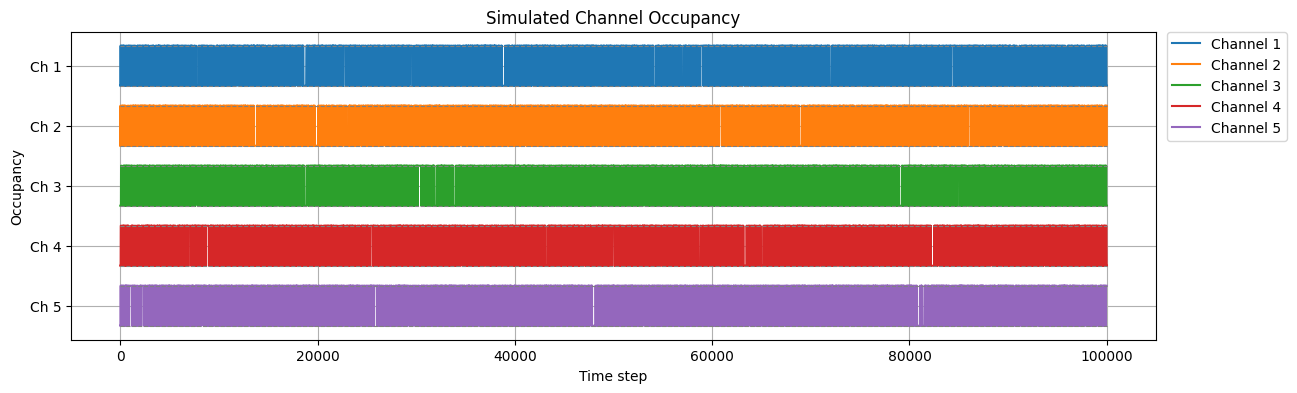

In [4]:
def simulate_multiple_channels(num_channels=config['num_channels'],
                               signal_length=config['signal_length'],
                               avg_duration=config['avg_duration']):
    channels = []
    for _ in range(num_channels):
        channel = []
        state = 0  # start with 0 or could randomize
        while len(channel) < signal_length:
            # Exponential duration for both states
            duration = np.random.exponential(scale=avg_duration)
            duration = int(max(1, round(duration)))
            channel.extend([state] * duration)
            state = 1 - state  # flip state
        # truncate to exact signal length
        channels.append(channel[:signal_length])

    return np.array(channels)

channel_data = simulate_multiple_channels()
plot_channels(channel_data, config['num_channels'])

## 5.&nbsp;Sequence creation & DataLoader
Converts channel data into X y sliding windows & creates PyTorch DataLoader

In [5]:
channel_data = channel_data.T # this transposes it to shape (time_steps, num_channels) for sequence slicing

def create_sequence(channel_data, input_window=100, horizon=config['horizon']):
  X = []  # past window
  y = []  # future horizon

  step = input_window + horizon # generate non-overlapping data
  max_start = len(channel_data) - step + 1

  for i in range(0, max_start, step):
    X.append(channel_data[i : i + input_window])
    y.append(channel_data[i + input_window : i + step])

  return np.array(X), np.array(y)

X, y = create_sequence(channel_data, input_window=100, horizon=config['horizon'])
print(f"X.shape = {X.shape}, y.shape = {y.shape}")
# will give you 891 training samples from the dataset, 100 time steps, 5 values per channel

# DataLoader part
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 64 # try out different values like 32 as well
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

X.shape = (990, 100, 5), y.shape = (990, 1, 5)


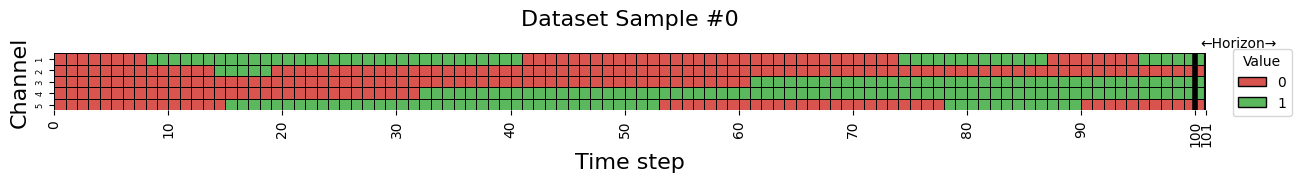

In [6]:
# Show heatmap sample from dataset
heatmap_dataset_sample_binary(X, y, sample_index=0)


## 6.&nbsp;LSTM model definition
Defines the LSTM model

In [7]:
class LSTM_model(nn.Module):
    def __init__(self, num_channels, horizon=config['horizon'], hidden_size=256):
        super().__init__()

        self.horizon = horizon # number of future time steps to predict
        self.num_channels = num_channels # number of channels/features in each input time step

        self.lstm = nn.LSTM( # defines the LSTM layer:
            input_size=num_channels, # input_size = num_channels: dimensionality of each input vector per time step (e.g., 5 channels)
            hidden_size=hidden_size, # hidden_size = 256: dimensionality of the hidden state
            batch_first=True # batch_first=True: input and output tensors have shape (batch, sequence_length, features)
        )
        self.fc = nn.Linear( # defines the fully connected (Linear) layer:
            hidden_size, # maps the final LSTM hidden state of size (hidden_size) to the prediction of 'horizon' future steps for each channel
            num_channels * horizon
        )

    def forward(self, x):  # x: (batch_size, 100, 5)
        out, _ = self.lstm(x) # out: (batch_size, 100, 256)
        last_out = out[:, -1, :] # last_out: (batch_size, 256)
        preds = self.fc(last_out) # preds: (batch_size, 10*5) = (batch_size, 50)
        preds = preds.view(-1, self.horizon, self.num_channels) # preds: (batch_size, 10, 5)
        return torch.sigmoid(preds) # returns probabilities in range [0,1]


## 7.&nbsp;Training loop
Training loop for model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Parameters
num_channels = X.shape[2]  # 5 channels
horizon = y.shape[1]       # 10 time steps ahead
loss_values = []
#epochs = 100
#lr = 0.001 # learning rate

model = LSTM_model(num_channels=num_channels, horizon=horizon)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.BCELoss()

# Variable to track best loss
best_loss = float('inf')
best_model_state = None  # to store the best model

# Training loop
for epoch in range(1, config['num_epochs'] +1):
  model.train()
  epoch_loss = 0.0

  for X_batch, y_batch in dataloader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    outputs = model(X_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * X_batch.size(0)

  avg_loss = epoch_loss / len(dataset)
  loss_values.append(avg_loss)
  print(f"Epoch {epoch}/{config['num_epochs']} - Loss: {avg_loss:.4f}")

  # Save best model
  if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()  # save model weights
        #print(f"  --> New best loss, saving model.")

# load the best model
model.load_state_dict(best_model_state)
print(f"Training complete. Best loss: {best_loss:.4f}")

Epoch 1/100 - Loss: 0.6610
Epoch 2/100 - Loss: 0.5478
Epoch 3/100 - Loss: 0.4575
Epoch 4/100 - Loss: 0.3691
Epoch 5/100 - Loss: 0.3062
Epoch 6/100 - Loss: 0.2654
Epoch 7/100 - Loss: 0.2367
Epoch 8/100 - Loss: 0.2260
Epoch 9/100 - Loss: 0.2077
Epoch 10/100 - Loss: 0.2022
Epoch 11/100 - Loss: 0.1881
Epoch 12/100 - Loss: 0.1812
Epoch 13/100 - Loss: 0.1788
Epoch 14/100 - Loss: 0.1709
Epoch 15/100 - Loss: 0.1626
Epoch 16/100 - Loss: 0.1577
Epoch 17/100 - Loss: 0.1491
Epoch 18/100 - Loss: 0.1423
Epoch 19/100 - Loss: 0.1390
Epoch 20/100 - Loss: 0.1280
Epoch 21/100 - Loss: 0.1301
Epoch 22/100 - Loss: 0.1122
Epoch 23/100 - Loss: 0.1158
Epoch 24/100 - Loss: 0.1028
Epoch 25/100 - Loss: 0.0987
Epoch 26/100 - Loss: 0.0987
Epoch 27/100 - Loss: 0.0857
Epoch 28/100 - Loss: 0.0872
Epoch 29/100 - Loss: 0.0797
Epoch 30/100 - Loss: 0.0786
Epoch 31/100 - Loss: 0.0779
Epoch 32/100 - Loss: 0.0687
Epoch 33/100 - Loss: 0.0616
Epoch 34/100 - Loss: 0.0559
Epoch 35/100 - Loss: 0.0551
Epoch 36/100 - Loss: 0.0441
E

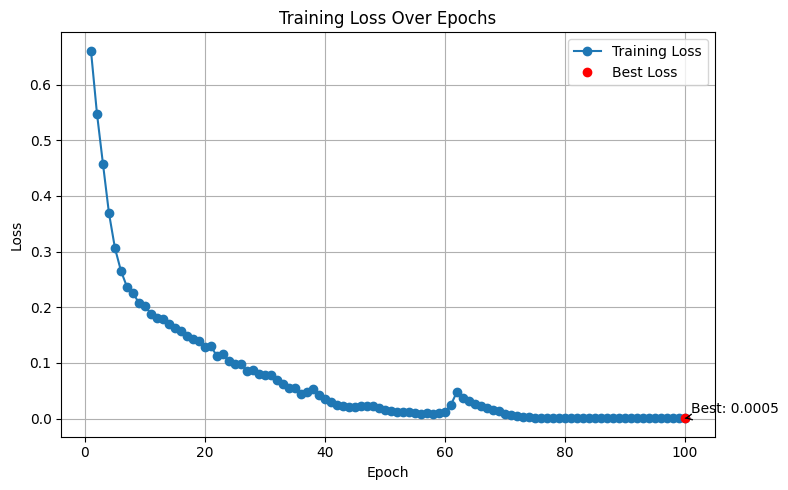

In [9]:
plot_loss(loss_values, config['num_epochs'])

## 8.&nbsp;Evaluate model on new dataset
Evaluates the trained model on new dataset using the same `avg_on_duration` & `avg_off_duration` values used during training, then on multiple (num_tests) new datasets (generated using `simulate_multiple_channels`)

In [10]:
def new_data(random_avg_duration=0, num_tests=1):
    # Determine avg_duration for this test, set to 0 to get random data
    if random_avg_duration == 0:
        avg_duration_used = random.randint(1, 100)
    else:
        avg_duration_used = random_avg_duration

    # Generate new dataset
    X_raw = simulate_multiple_channels(
        num_channels=config['num_channels'],
        signal_length=config['signal_length'],
        avg_duration=avg_duration_used
    )

    # Transpose for sequence creation (time_steps, num_channels)
    X_raw_T = X_raw.T

    # Create sequences for the model
    test_X, test_y = create_sequence(
        X_raw_T,
        input_window=config['input_window'],
        horizon=config['horizon']
    )

    # Convert to tensors and move to device
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(config['device'])
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(config['device'])

    return test_X_tensor, test_y_tensor, X_raw_T, avg_duration_used


def run_tests(num_tests):

    rows = []
    saved_results = []

    # Load best model
    model.load_state_dict(best_model_state)
    model.to(config['device'])
    model.eval()
    print(f"Loaded best model with loss: {best_loss:.4f}")

    for i in range(num_tests):
        # Generate new test data with random avg_duration
        test_X_tensor, test_y_tensor, X_raw_T, avg_duration_used = new_data(0)

        with torch.no_grad():
            preds = model(test_X_tensor)

        # Convert predictions to binary
        preds_binary = (preds >= 0.5).int()

        # Compute accuracy
        correct = (preds_binary == test_y_tensor.int()).sum().item()
        total = torch.numel(test_y_tensor)
        acc_percent = (correct / total) * 100

        # Reconstruct full-length prediction for plotting/analysis
        pred_full, X_raw = reconstruct_full_prediction(preds_binary, X_raw_T, horizon=config['horizon'])

        # Save results
        saved_results.append((pred_full, X_raw, preds_binary.cpu().numpy(), avg_duration_used, acc_percent))

        # Format row for printing
        rows.append(f"{i+1:02d}\t{avg_duration_used}\t{acc_percent:.2f}")

    # Print summary table
    print("Test\tavg_duration\tAccuracy (%)")
    for r in rows:
        print(r)

    # Calculate and print average accuracy
    avg_acc = sum([res[4] for res in saved_results]) / len(saved_results)
    print(f"\nAverage accuracy over {num_tests} tests: {avg_acc:.2f}%")

    return rows, saved_results


def reconstruct_full_prediction(preds_binary, X_raw_T, horizon=config['horizon']):
    """
    Reconstruct full-length prediction from overlapping windows.

    preds_binary: torch.Tensor of shape (num_samples, horizon, num_channels)
    X_raw_T: numpy array (time_steps, num_channels)
    horizon: steps predicted per input sequence

    Returns:
        pred_full: numpy array (num_channels, signal_length)
        X_raw: numpy array (num_channels, signal_length)
    """

    preds_np = preds_binary.cpu().numpy()  # (num_samples, horizon, num_channels)
    num_samples, horizon, num_channels = preds_np.shape

    # Reconstruct the original signal orientation (num_channels, signal_length)
    X_raw = X_raw_T.T  # (time_steps, channels) -> (channels, time_steps)
    signal_length = X_raw.shape[1]

    pred_full = np.zeros((num_channels, signal_length))

    for i in range(num_samples):
        start = i
        end = min(i + horizon, signal_length)
        pred_full[:, start:end] = preds_np[i, :end-start, :].T

    return pred_full, X_raw

# Calls
table, results = run_tests(20)
pred_full, X_raw, preds_binary, avg_duration, acc = results[0] # store the data from test #1

Loaded best model with loss: 0.0005
Test	avg_duration	Accuracy (%)
01	45	92.86
02	94	97.19
03	37	92.16
04	47	94.07
05	48	94.27
06	3	60.20
07	92	96.78
08	33	91.66
09	67	95.88
10	39	93.37
11	99	97.09
12	25	91.76
13	45	94.07
14	58	94.47
15	67	96.28
16	11	82.01
17	43	93.17
18	46	93.27
19	1	52.16
20	65	93.97

Average accuracy over 20 tests: 89.83%


In [11]:
# test on same avg_duration used during training
def run_tests_training(num_tests):

    rows = []
    saved_results = []

    # Load best model
    model.load_state_dict(best_model_state)
    model.to(config['device'])
    model.eval()
    print(f"Loaded best model with loss: {best_loss:.4f}")

    # Use training avg_duration from config
    training_avg_duration = config['avg_duration']

    for i in range(num_tests):
        # Generate test data with same avg_duration as training
        test_X_tensor, test_y_tensor, X_raw_T, avg_duration_used = new_data(training_avg_duration)

        with torch.no_grad():
            preds = model(test_X_tensor)

        # Convert predictions to binary
        preds_binary = (preds >= 0.5).int()

        # Compute accuracy
        correct = (preds_binary == test_y_tensor.int()).sum().item()
        total = torch.numel(test_y_tensor)
        acc_percent = (correct / total) * 100

        # Reconstruct full-length prediction for plotting/analysis
        pred_full, X_raw = reconstruct_full_prediction(preds_binary, X_raw_T, horizon=config['horizon'])

        # Save results
        saved_results.append((pred_full, X_raw, preds_binary.cpu().numpy(), avg_duration_used, acc_percent))

        # Format row for printing
        rows.append(f"{i+1:02d}\t{avg_duration_used}\t{acc_percent:.2f}")

    # Print summary table
    print("Test\tavg_duration\tAccuracy (%)")
    for r in rows:
        print(r)

    # Calculate and print average accuracy across all tests
    avg_acc = sum([res[4] for res in saved_results]) / len(saved_results)
    print(f"\nAverage accuracy over {num_tests} tests: {avg_acc:.2f}%")

    return rows, saved_results


table, results = run_tests_training(40)

Loaded best model with loss: 0.0005
Test	avg_duration	Accuracy (%)
01	40	94.37
02	40	92.66
03	40	92.56
04	40	92.86
05	40	93.07
06	40	92.16
07	40	93.07
08	40	92.46
09	40	92.56
10	40	92.46
11	40	94.17
12	40	92.06
13	40	93.97
14	40	93.97
15	40	92.56
16	40	93.07
17	40	93.07
18	40	91.96
19	40	93.47
20	40	93.77
21	40	93.87
22	40	93.47
23	40	93.17
24	40	92.06
25	40	92.66
26	40	92.56
27	40	93.57
28	40	93.47
29	40	94.07
30	40	92.26
31	40	93.37
32	40	92.66
33	40	94.17
34	40	91.56
35	40	92.56
36	40	92.36
37	40	93.77
38	40	93.07
39	40	93.37
40	40	93.67

Average accuracy over 40 tests: 93.05%


In [ ]:
# graphs are no longer "relevant" due to increase in data, require reformat
#plot_compare_channels(X_raw, pred_full) # shows data from test 01

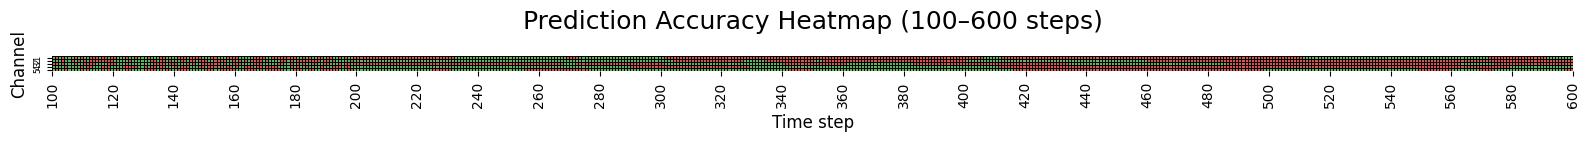

In [ ]:
#heatmap_correctness_100(X_raw, pred_full) # shows data from test 01